# Diagnosis of problems revealed in benchmarks

This notebook performs some diagnosis for problems identified from [this benchmark](https://gaow.github.io/mvarbvs/analysis/20191116_MNM_Benchmark.html).

In [1]:
%cd ~/GIT/mvarbvs/dsc_mnm

/project2/mstephens/gaow/mvarbvs/dsc_mnm

Here I load previous benchmark results and identify some scenarios where there is a problem,

In [2]:
out = readRDS('../data/finemap_output.20191116.rds')

In [3]:
res = out[,-1]
colnames(res) = c('n_traits', 'resid_method', 'missing', 'EZ_model', 'L', 'total', 'valid', 'size', 'purity', 'top_hit', 'total_true', 'total_true_included', 'overlap_var', 'overlap_cs', 'false_positive_cross_cond', 'false_negative_cross_cond', 'true_positive_cross_cond', 'elbo_converged', 'filename')

In [4]:
bad = res[which(res$total-res$valid>3),]

In [5]:
bad[which(bad$missing==TRUE & bad$EZ_model==1 & bad$n_traits==5),]

,n_traits,resid_method,missing,EZ_model,L,total,valid,size,purity,top_hit,total_true,total_true_included,overlap_var,overlap_cs,false_positive_cross_cond,false_negative_cross_cond,true_positive_cross_cond,elbo_converged,filename
5340,5,oracle,TRUE,1,10,6,0,1,1,0,1,0,0,0,30,0,0,TRUE,susie_scores/full_data_340_high_het_1_oracle_generator_1_mnm_high_het_6_susie_scores_1
5452,5,oracle,TRUE,1,10,9,0,1,1,0,1,0,0,0,45,0,0,TRUE,susie_scores/full_data_452_high_het_1_oracle_generator_1_mnm_high_het_6_susie_scores_1
17340,5,diag,TRUE,1,10,6,0,1,1,0,1,0,0,0,30,0,0,TRUE,susie_scores/full_data_340_high_het_1_oracle_generator_1_mnm_high_het_18_susie_scores_1
17452,5,diag,TRUE,1,10,9,0,1,1,0,1,0,0,0,45,0,0,TRUE,susie_scores/full_data_452_high_het_1_oracle_generator_1_mnm_high_het_18_susie_scores_1
29340,5,flash,TRUE,1,10,6,0,1,1,0,1,0,0,0,30,0,0,TRUE,susie_scores/full_data_340_high_het_1_oracle_generator_1_mnm_high_het_30_susie_scores_1
29452,5,flash,TRUE,1,10,9,0,1,1,0,1,0,0,0,45,0,0,TRUE,susie_scores/full_data_452_high_het_1_oracle_generator_1_mnm_high_het_30_susie_scores_1


Load the first line of dataset identified,

In [2]:
ex = readRDS('mnm_20191116/mnm_high_het/full_data_340_high_het_1_oracle_generator_1_mnm_high_het_6.rds')
# cat(ex$DSC_DEBUG$script)
DSC_19D98699 <- dscrutils::load_inputs(c('mnm_20191116/oracle_generator/oracle_generator_1.pkl','mnm_20191116/full_data/full_data_340.rds','mnm_20191116/high_het/full_data_340_high_het_1.pkl'), dscrutils::read_dsc)
meta <- DSC_19D98699$meta

The original result from DSC is presented in a plot of PIP and CS, where true signal is in red:

In [3]:
true_pos = as.integer(apply(meta$true_coef, 1, sum) != 0)

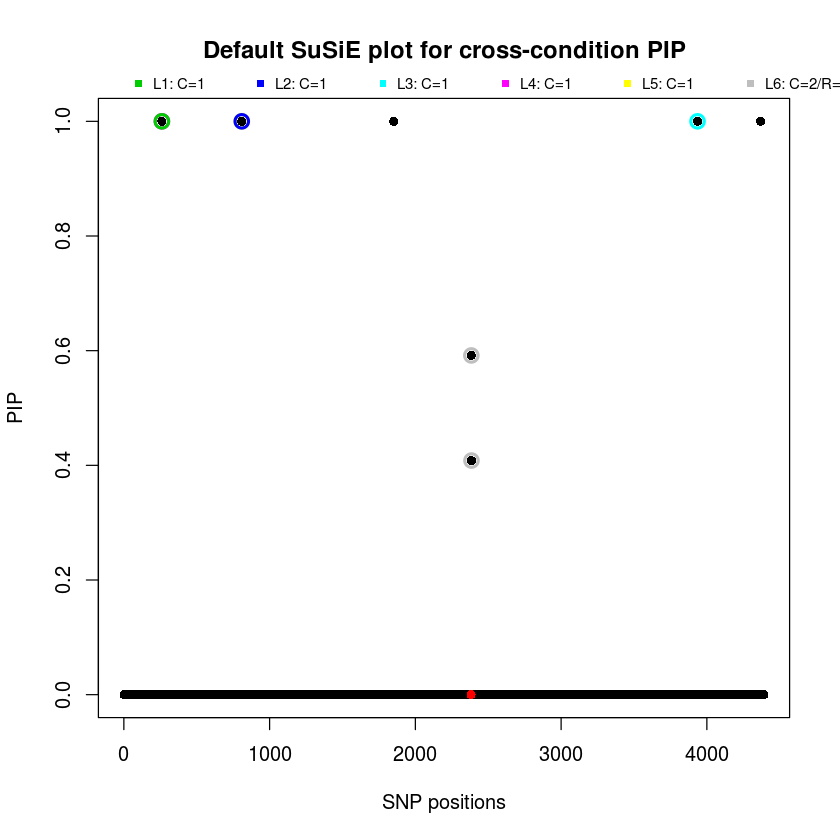

In [4]:
susieR::susie_plot(ex$result,y='PIP', main = 'Default SuSiE plot for cross-condition PIP', xlab = 'SNP positions', add_legend = T, b=true_pos)

It seems it completely missed out the causal variant.

When analyzed with non-missing data input the result looks good (analysis changing `missing_Y` to `FALSE` is not shown here).

## Reproducing the problem with diagnostic information

Below I use simplified code from DSC script, and use `L=1` and `max_iter=1` this time to make it easier to manage.

Additionally I temporarily changed the source code to:

1. force using the same code to handle missing and non-missing data inputs, to rule out errors specific to codes dealing with missing data
2. print quantities $X^Tr$, $\hat{\beta}$, $\text{SE}(\hat{\beta})$

It is verified that setting `precompute_covariances` to `T` or `F` does not impact the result. For when there is missing data and residual variance is not diagonal, `mmbr` forces precomputing covariances to deal with missing data specifically for off-diag elements of various quantities. But since here the residual variance is diagonal matrix the off-diag elements will all be zero anyways -- that is, missing data will not impact off-diag elements in this case.

```diff
diff --git a/R/mash_multiple_regression.R b/R/mash_multiple_regression.R
index bf50368..f012173 100644
--- a/R/mash_multiple_regression.R
+++ b/R/mash_multiple_regression.R
@@ -31,6 +31,9 @@ MashMultipleRegression <- R6Class("MashMultipleRegression",
       else XtY = d$XtY
       # OLS estimates
       # bhat is J by R
+      print('---XtY---')
+      rownames(XtY) = NULL
+      print(head(XtY))
       bhat = XtY / d$d
       if (!is.null(private$precomputed_cov_matrices)) {
         sbhat = private$precomputed_cov_matrices$sbhat
@@ -55,6 +58,11 @@ MashMultipleRegression <- R6Class("MashMultipleRegression",
         s_alpha = matrix(0,0,0)
       }
       bhat[which(is.nan(bhat))] = 0
+      rownames(bhat) = NULL
+      print('---bhat---')
+      print(head(bhat))
+      print('---sbhat---')
+      print(head(sbhat))
       # Fit MASH model
       if (!is.null(private$precomputed_cov_matrices)) is_common_cov = private$precomputed_cov_matrices$common_sbhat
       else is_common_cov = is_mat_common(sbhat)
diff --git a/R/regression_data.R b/R/regression_data.R
index b19db2e..583b1eb 100644
--- a/R/regression_data.R
+++ b/R/regression_data.R
@@ -15,6 +15,7 @@ DenseData <- R6Class("DenseData",
       Y_missing = is.na(Y)
       private$Y_non_missing = !Y_missing
       private$.Y_has_missing = any(Y_missing)
+      private$.Y_has_missing = TRUE
       private$standardize(center,scale)
       private$residual = private$.Y
     },
```

(Use `git apply filename.diff` to apply the patch.)

In [5]:
DSC_REPLICATE <- DSC_19D98699$DSC_DEBUG$replicate
X <- DSC_19D98699$X
Y <- DSC_19D98699$Y
cfg <- DSC_19D98699$configurations
prior = cfg[[as.character(ncol(Y))]][['high_het']]

In [6]:
set.seed(DSC_REPLICATE)
compute_cov_diag <- function(Y){
    covar <- diag(apply(Y, 2, var, na.rm=T))
    return(covar)
}

create_missing <- function(Y1, Y0) {
    if (ncol(Y0) < ncol(Y1)) {
        for (i in 1:(ncol(Y1) - ncol(Y0))) {
            Y0 = cbind(Y0, sample(Y0[, sample.int(ncol(Y0), size=1)]))
        }
    }
    if (ncol(Y0) > ncol(Y1)) Y0 = Y0[,sample(1:ncol(Y1))]
    res = Y1
    res[which(is.na(Y0))] = NA
    na_rows = which(apply(res, 1, function(x) all(is.na(x))))
    for (i in na_rows) {
	    non_na = sample.int(ncol(res), size=1)
        res[i,non_na] = Y1[i,non_na]
    }
    return(res)
}

In [7]:
Y_miss = create_missing(Y, meta$original_Y)
resid_Y <- compute_cov_diag(Y)

This data-set has also been saved to [here](https://github.com/gaow/mmbr/issues/9#issue-531283569). If you want to reproduce my results you can download the data-set from the link above, use `attach(readRDS(...))` to attach the data to the R workspace and continue with commands below.

Use EE model and set $L=1$,

In [8]:
alpha = 0
L = 1

Then fit with complete data, and with missing data:

In [9]:
m_init = mmbr:::MashInitializer$new(NULL, NULL, xUlist=append(list(matrix(0,ncol(Y),ncol(Y))), prior$xUlist), prior_weights=prior$pi, null_weight=prior$null_weight, alpha=alpha, top_mixtures=-1)
r1 = mmbr::msusie(X, Y, L=L, prior_variance=m_init, residual_variance=resid_Y, compute_objective=F, estimate_residual_variance=F, estimate_prior_variance=F, precompute_covariance = F, standardize=T, max_iter=1)

In [10]:
m_init = mmbr:::MashInitializer$new(NULL, NULL, xUlist=append(list(matrix(0,ncol(Y),ncol(Y))), prior$xUlist), prior_weights=prior$pi, null_weight=prior$null_weight, alpha=alpha, top_mixtures=-1)
r2 = mmbr::msusie(X, Y_miss, L=L, prior_variance=m_init, residual_variance=resid_Y, compute_objective=F, estimate_residual_variance=F, estimate_prior_variance=F, precompute_covariance = F, standardize=T, max_iter=1)

To plot and compare results,

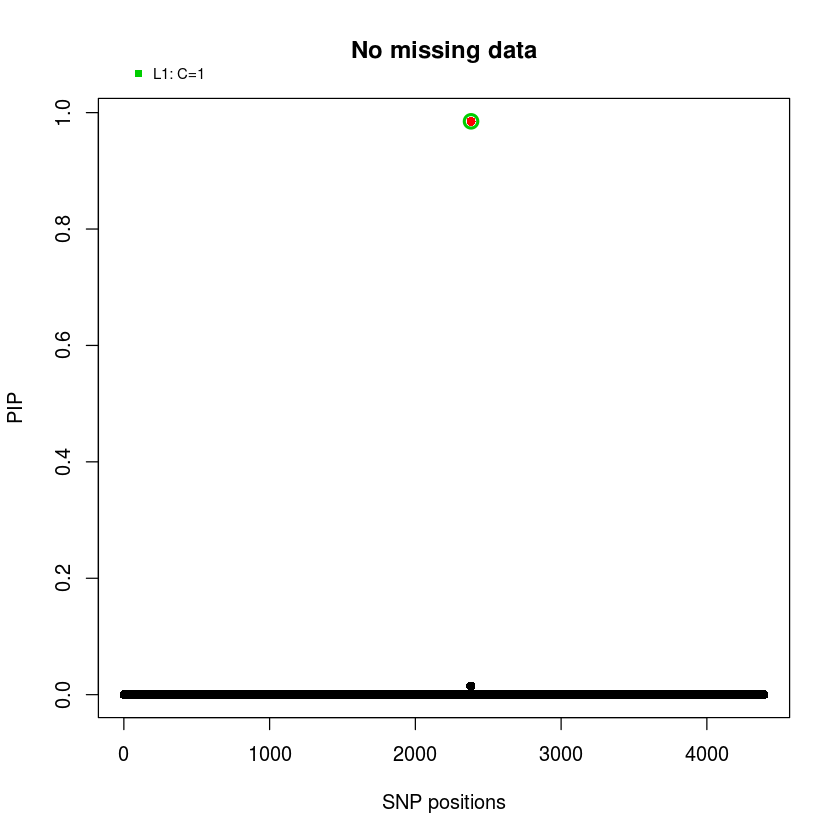

In [11]:
susieR::susie_plot(r1, y='PIP', main = 'No missing data', xlab = 'SNP positions', add_legend = T, b=true_pos)

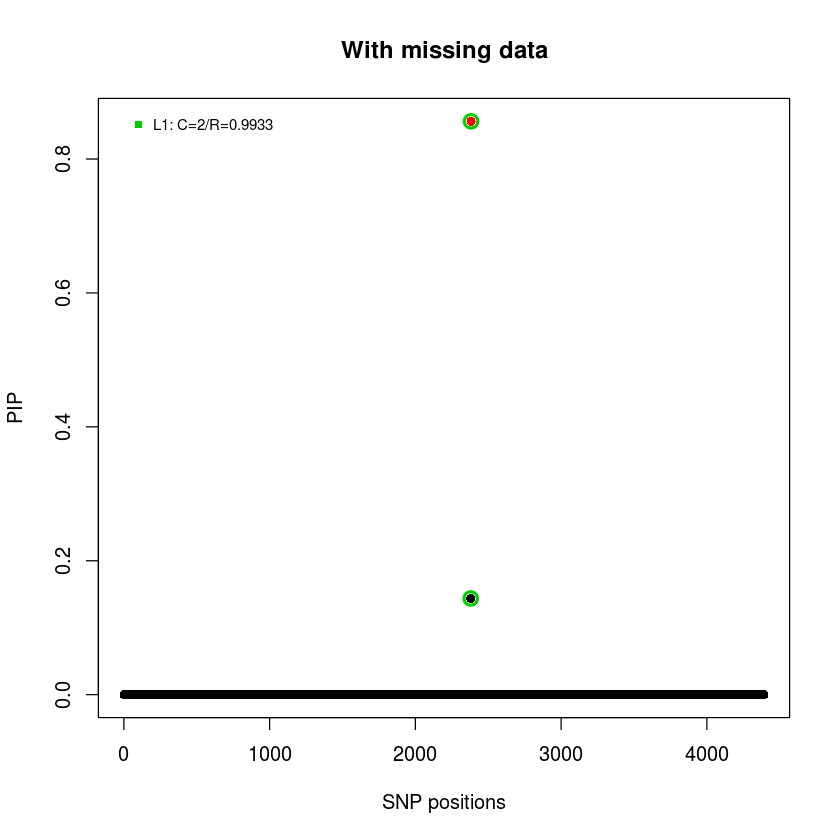

In [12]:
susieR::susie_plot(r2,y='PIP', main = 'With missing data', xlab = 'SNP positions', add_legend = T, b=true_pos)

Problem reproduced with `L=1`. I would expect for such case after randomly removing what happens to be important information in data, there should be a power loss and we should not detect anything. But here, rather, it reports a false signal that we don't like.

## More diagnosis from single effect model

For complete data,

In [14]:
m_init = mmbr:::MashInitializer$new(NULL, NULL, xUlist=append(list(matrix(0,ncol(Y),ncol(Y))), prior$xUlist), prior_weights=prior$pi, null_weight=prior$null_weight, alpha=alpha, top_mixtures=-1)
m1 = mmbr:::MashRegression$new(ncol(X), resid_Y, m_init)
m1$fit(mmbr:::DenseData$new(X, Y), save_summary_stats=TRUE)

In [15]:
max(abs(m1$bhat/m1$sbhat))

[1] 9.726096

In [16]:
which.max(apply(abs(m1$bhat/m1$sbhat), 1, max))

chr12_12983795_G_T_b38 
                  2382

For missing data,

In [18]:
m_init = mmbr:::MashInitializer$new(NULL, NULL, xUlist=append(list(matrix(0,ncol(Y),ncol(Y))), prior$xUlist), prior_weights=prior$pi, null_weight=prior$null_weight, alpha=alpha, top_mixtures=-1)
m2 = mmbr:::MashRegression$new(ncol(X), resid_Y, m_init)
m2$fit(mmbr:::DenseData$new(X, Y_miss), save_summary_stats=TRUE)

In [20]:
max(abs(m2$bhat/m2$sbhat),na.rm=T)

[1] 7.544221

The max z-score is 253 -- very problematic.

In [54]:
head(m2$bhat/m2$sbhat, 10)

chr12_11891261_T_C_b38,0.4948717,-1.7559292,0.3815011,-10.8785034,0.05368848
chr12_11891459_T_TTA_b38,-1.1523837,0.7407770,-0.4661889,10.2332597,0.40654244
chr12_11892022_GAGCGC_G_b38,1.7130447,-2.7367410,1.3690730,1.1375130,-0.46137775
chr12_11892251_T_C_b38,-0.3714647,0.4306859,-0.4341265,-10.0125233,0.76711878
chr12_11892330_G_T_b38,0.7703803,-1.3640789,0.6086061,37.7076708,0.85151069
chr12_11893016_C_T_b38,1.5577940,-2.0090443,1.3341945,55.0781512,0.03756813
chr12_11893355_C_CAAAG_b38,0.9896949,-0.7942333,0.8687819,17.6638363,-0.01745624
chr12_11893407_A_G_b38,1.0823336,-0.9151114,0.9533810,0.4000107,0.22639267
chr12_11893495_A_G_b38,-0.2970784,0.5592687,-0.2973645,-9.9247467,0.60814695
chr12_11893724_T_C_b38,0.7911152,-1.3464565,0.9176490,-10.7181873,0.44425421


The 4th column (4th condition) has large z-scores. This is consistent with observed difference in $X^TY$ between missing and non-missing scenarios as shown in the debug log above. Removing the 4th condition:

In [56]:
max(abs(m2$bhat/m2$sbhat)[,-4])

[1] 7.489221

To find which row it is in:

In [58]:
which.max(apply(abs(m2$bhat/m2$sbhat)[,-4], 1, max))

chr12_12983795_G_T_b38 
                  2382

This is indeed the true causal SNP.

Now checkout the logBF:

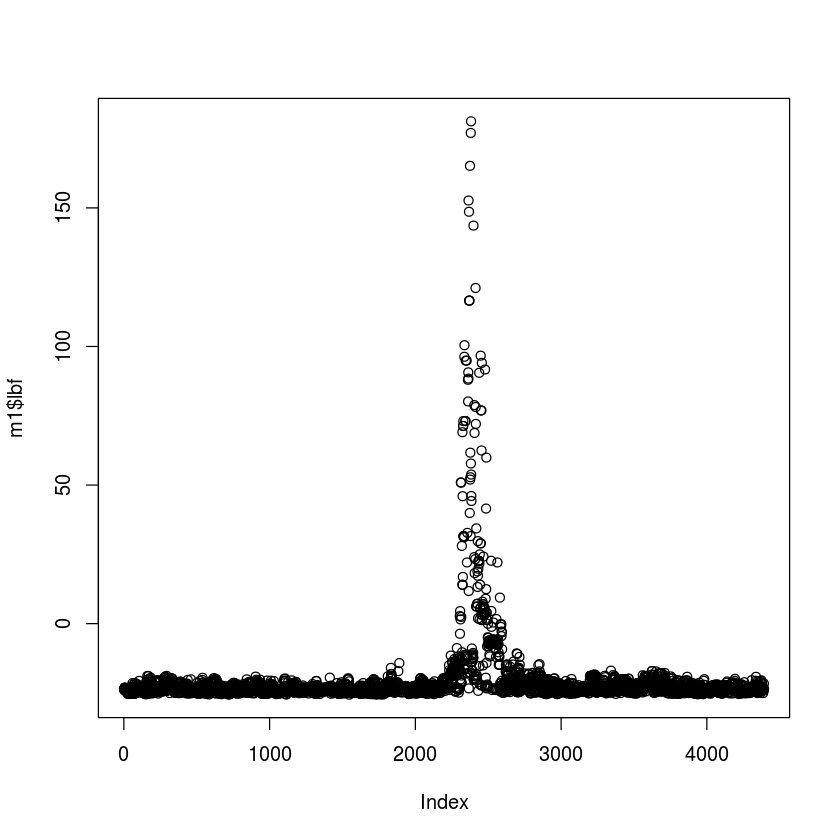

In [38]:
plot(m1$lbf)

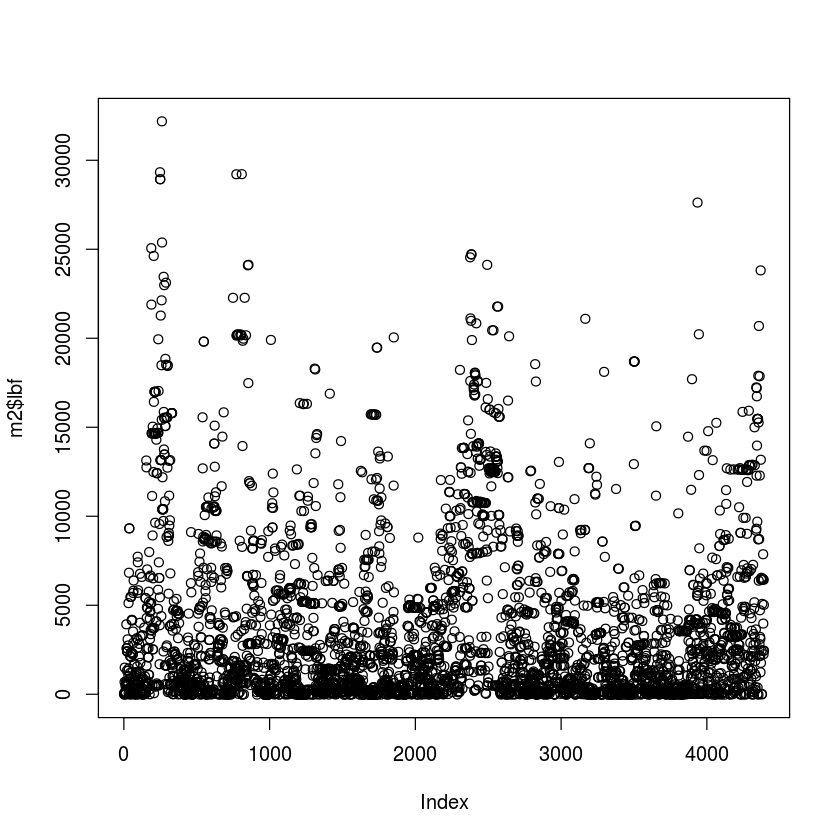

In [39]:
plot(m2$lbf)

The lbf here are not under the null. They are insanely large! In particular the Log BF for the false positive variable in the presense of missing data is a lot higher than where the simulated signal lies, thus the false positive result.

This must be a very obvious bug because the marginal statistics is even wrong here with missing data. It is easy to show that with `susieR::univariate_regression` function the result for missing data is very different from what I got here above.

## More diagnosis using precomputed quantities

Missingness across samples:

In [18]:
summary(apply(Y_miss,1,function(i) sum(is.na(i)))/ ncol(Y_miss))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.4000  0.6000  0.5332  0.8000  0.8000 

Missingness across conditions:

In [19]:
apply(Y_miss,2,function(i) sum(is.na(i))) / nrow(Y_miss)

[1] 0.4284010 0.7255370 0.5202864 0.7004773 0.2911695

Precomputed quantities with this data-set, compared with complete data:

In [20]:
m1 = mmbr:::MashInitializer$new(NULL, NULL, xUlist=append(list(matrix(0,ncol(Y),ncol(Y))), prior$xUlist), prior_weights=prior$pi, null_weight=prior$null_weight, alpha=alpha, top_mixtures=-1)
m1$precompute_cov_matrices(mmbr:::DenseData$new(X, Y_miss), resid_Y)
m2 = mmbr:::MashInitializer$new(NULL, NULL, xUlist=append(list(matrix(0,ncol(Y),ncol(Y))), prior$xUlist), prior_weights=prior$pi, null_weight=prior$null_weight, alpha=alpha, top_mixtures=-1)
m2$precompute_cov_matrices(mmbr:::DenseData$new(X, Y), resid_Y)

In [21]:
matrix(m1$precomputed$Vinv, ncol(Y), ncol(Y))

1214.26,0.0,0.00,0,0.00
0.00,792611.9,0.00,0,0.00
0.00,0.0,20833.67,0,0.00
0.00,0.0,0.00,2758273474,0.00
0.00,0.0,0.00,0,1429.66


In [23]:
matrix(m2$precomputed$Vinv, ncol(Y), ncol(Y))

2133.148,0,0.00,0,0.000
0.000,2932304,0.00,0,0.000
0.000,0,43738.31,0,0.000
0.000,0,0.00,9346578303,0.000
0.000,0,0.00,0,2022.378


In [24]:
matrix(m1$precomputed$U0, ncol(Y), 2*ncol(Y))

0,0,0,0,0,8.148494e-04,1.906389e-09,7.247793e-08,5.478265e-13,1.046093e-06
0,0,0,0,0,1.906389e-09,1.261631e-06,1.123868e-10,8.494792e-16,1.622109e-09
0,0,0,0,0,7.247793e-08,1.123868e-10,4.796938e-05,3.229586e-14,6.167003e-08
0,0,0,0,0,5.478265e-13,8.494792e-16,3.229586e-14,3.625456e-10,4.661347e-13
0,0,0,0,0,1.046093e-06,1.622109e-09,6.167003e-08,4.661347e-13,6.931832e-04


In [25]:
matrix(m2$precomputed$U0, ncol(Y), 2*ncol(Y))

0,0,0,0,0,4.659596e-04,2.945486e-10,1.974054e-08,9.240926e-14,4.239708e-07
0,0,0,0,0,2.945486e-10,3.410273e-07,1.446021e-11,6.769101e-17,3.105642e-10
0,0,0,0,0,1.974054e-08,1.446021e-11,2.285648e-05,4.536627e-15,2.081390e-08
0,0,0,0,0,9.240926e-14,6.769101e-17,4.536627e-15,1.069910e-10,9.743387e-14
0,0,0,0,0,4.239708e-07,3.105642e-10,2.081390e-08,9.743387e-14,4.913185e-04


In [26]:
matrix(m1$precomputed$sigma_rooti, ncol(Y), 2*ncol(Y))

34.84624,0.0000,0.0000,0.00,0.00000,3.3181863,0.0000000,0.0000000,0.000000,0.000000
0.00000,890.2875,0.0000,0.00,0.00000,-0.8525948,3.4415861,0.0000000,0.000000,0.000000
0.00000,0.0000,144.3387,0.00,0.00000,-0.6955920,-0.7040655,3.5118934,0.000000,0.000000
0.00000,0.0000,0.0000,52519.27,0.00000,-0.5879181,-0.5950800,-0.5946683,3.562940,0.000000
0.00000,0.0000,0.0000,0.00,37.81085,-0.5067246,-0.5128975,-0.5125426,-0.512907,3.583793


In [27]:
matrix(m2$precomputed$sigma_rooti, ncol(Y), 2*ncol(Y))

46.18601,0.000,0.0000,0.0,0.00000,3.3246858,0.0000000,0.0000000,0.0000000,0.000000
0.00000,1712.397,0.0000,0.0,0.00000,-0.8560536,3.4420504,0.0000000,0.0000000,0.000000
0.00000,0.000,209.1371,0.0,0.00000,-0.6986672,-0.7035159,3.5127415,0.0000000,0.000000
0.00000,0.000,0.0000,96677.7,0.00000,-0.5904793,-0.5945772,-0.5943788,3.5631757,0.000000
0.00000,0.000,0.0000,0.0,44.97086,-0.5096622,-0.5131993,-0.5130281,-0.5132019,3.588697


In [28]:
head(m1$precomputed$sbhat)

0.02869750,0.0011232326,0.006928147,1.904063e-05,0.02644744
0.02906392,0.0012040300,0.007027235,1.998521e-05,0.02686400
0.02783022,0.0010127240,0.006782524,1.743423e-05,0.02551239
0.02879181,0.0011829917,0.006932235,2.002191e-05,0.02701386
0.02872013,0.0011189630,0.006903280,1.887977e-05,0.02645334
0.02832716,0.0009989913,0.006762060,1.692667e-05,0.02541736


In [29]:
head(m2$precomputed$sbhat)

0.02165158,0.0005839767,0.004781553,1.034365e-05,0.02223662
0.02165158,0.0005839767,0.004781553,1.034365e-05,0.02223662
0.02165158,0.0005839767,0.004781553,1.034365e-05,0.02223662
0.02165158,0.0005839767,0.004781553,1.034365e-05,0.02223662
0.02165158,0.0005839767,0.004781553,1.034365e-05,0.02223662
0.02165158,0.0005839767,0.004781553,1.034365e-05,0.02223662


The outcome are largely comparable.